<a href="https://colab.research.google.com/github/harshrew19/FORE/blob/main/Efficient_Frontier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt

In [12]:
import plotly.express as px

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
from google.colab import drive
drive.mount('/gdrive')


Mounted at /gdrive


In [4]:
path = "/gdrive/MyDrive/BDA DLNLP/Project/P-Portfolio_prices.csv"


In [5]:
df0 = pd.read_csv(path)
df1 = df0.set_index('Date')
df1.head()

,Wipro,Reliance,Tata Power,Tech Mahindra,Tata Motors,Tata Chemicals,TVS Motors,LTI Mindtree,Hindustan Aeronauticals,Suzlon Energy,Jindal Stainless
Date,,,,,,,,,,,
01-07-2022,420.963135,2393.016357,205.089966,929.639465,411.417755,781.432007,856.225281,3933.699463,1697.212524,6.75,99.075859
04-07-2022,419.267303,2397.983887,209.498901,919.751709,407.180939,789.292053,836.771240,3909.462646,1736.460938,6.65,99.522583
05-07-2022,412.583771,2417.406738,210.836456,922.741089,410.719910,789.341187,808.411194,3892.698975,1719.549438,6.65,100.068604
06-07-2022,415.027740,2396.146240,212.025375,928.903748,415.056396,798.920593,821.048767,3945.498047,1707.867798,6.60,99.075859
07-07-2022,419.766083,2372.550781,212.570297,938.883484,429.511353,805.306824,821.894653,3977.403564,1696.723755,6.60,102.848274


<Figure size 1500x600 with 0 Axes>

Text(0, 0.5, 'Price in $')

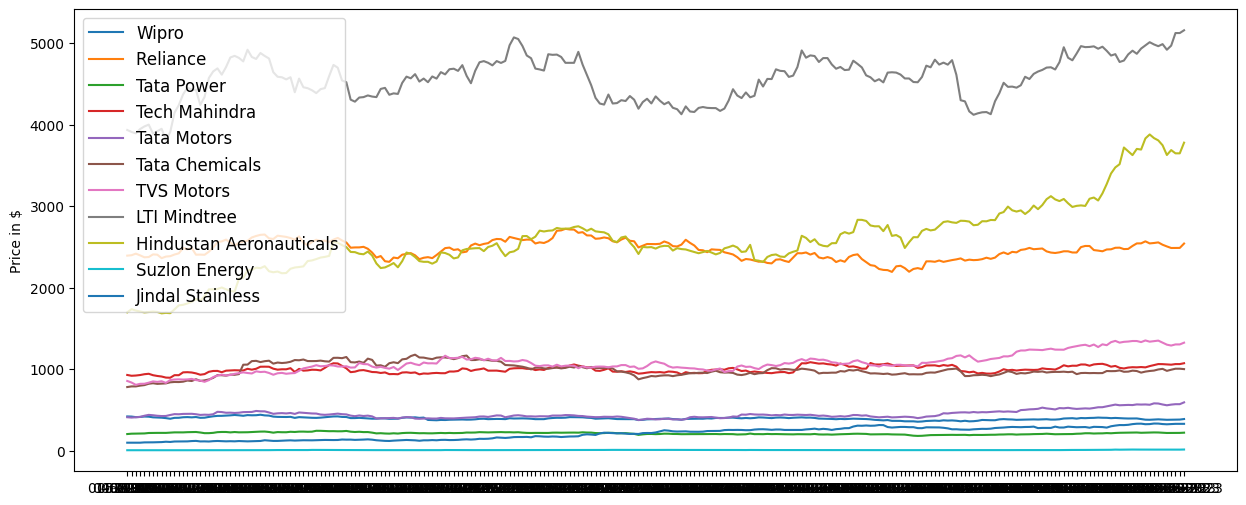

In [6]:
plt.figure(figsize=(15, 6))
for i in range(df1.shape[1]):
    plt.plot(df1.iloc[:,i], label=df1.columns.values[i])
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('Price in $')
plt.show()

In [7]:
#Calculate daily changes in the stocks' value
df2 = df1.pct_change()
#Remove nan values at the first row of df2. Create a new dataframe df
df=df2.iloc[1:len(df2.index),:]
# Calculate annualized average return for each stock. Annualized average return = Daily average return * 252 business days.
r = np.mean(df,axis=0)*252

# Create a covariance matrix
covar = df.cov()

In [8]:
#Define frequently used functions.
# r is each stock's return, w is the portion of each stock in our portfolio, and covar is the covariance matrix
# Rate of return
def ret(r,w):
    return r.dot(w)
# Risk level - or volatility
def vol(w,covar):
    return np.sqrt(np.dot(w,np.dot(w,covar)))
def sharpe (ret,vol):
    return ret/vol

In [9]:
# All weights, of course, must be between 0 and 1. Thus we set 0 and 1 as the boundaries.
from scipy.optimize import Bounds
bounds = Bounds(0, 1)

# The second boundary is the sum of weights.
from scipy.optimize import LinearConstraint
linear_constraint = LinearConstraint(np.ones((df2.shape[1],), dtype=int),1,1)

# Find a portfolio with the minimum risk.
from scipy.optimize import minimize
#Create x0, the first guess at the values of each stock's weight.
weights = np.ones(df2.shape[1])
x0 = weights/np.sum(weights)
#Define a function to calculate volatility
fun1 = lambda w: np.sqrt(np.dot(w,np.dot(w,covar)))
res = minimize(fun1,x0,method='trust-constr',constraints = linear_constraint,bounds = bounds)

#These are the weights of the stocks in the portfolio with the lowest level of risk possible.
w_min = res.x

np.set_printoptions(suppress = True, precision=2)
print(w_min)
print('return: % .2f'% (ret(r,w_min)*100), 'risk: % .3f'% vol(w_min,covar))

[0.29 0.27 0.07 0.08 0.   0.08 0.14 0.   0.03 0.   0.05]
return:  20.42 risk:  0.009


In [10]:
#Define 1/Sharpe_ratio
fun2 = lambda w: np.sqrt(np.dot(w,np.dot(w,covar)))/r.dot(w)
res_sharpe = minimize(fun2,x0,method='trust-constr',constraints = linear_constraint,bounds = bounds)

#These are the weights of the stocks in the portfolio with the highest Sharpe ratio.
w_sharpe = res_sharpe.x
print(w_sharpe)
print('return: % .2f'% (ret(r,w_sharpe)*100), 'risk: % .3f'% vol(w_sharpe,covar))

[0.   0.   0.   0.   0.   0.   0.19 0.08 0.32 0.03 0.39]
return:  92.93 risk:  0.014


<Figure size 2000x1000 with 0 Axes>

Text(0.5, 0, 'Volatility')

Text(0, 0.5, 'Return')

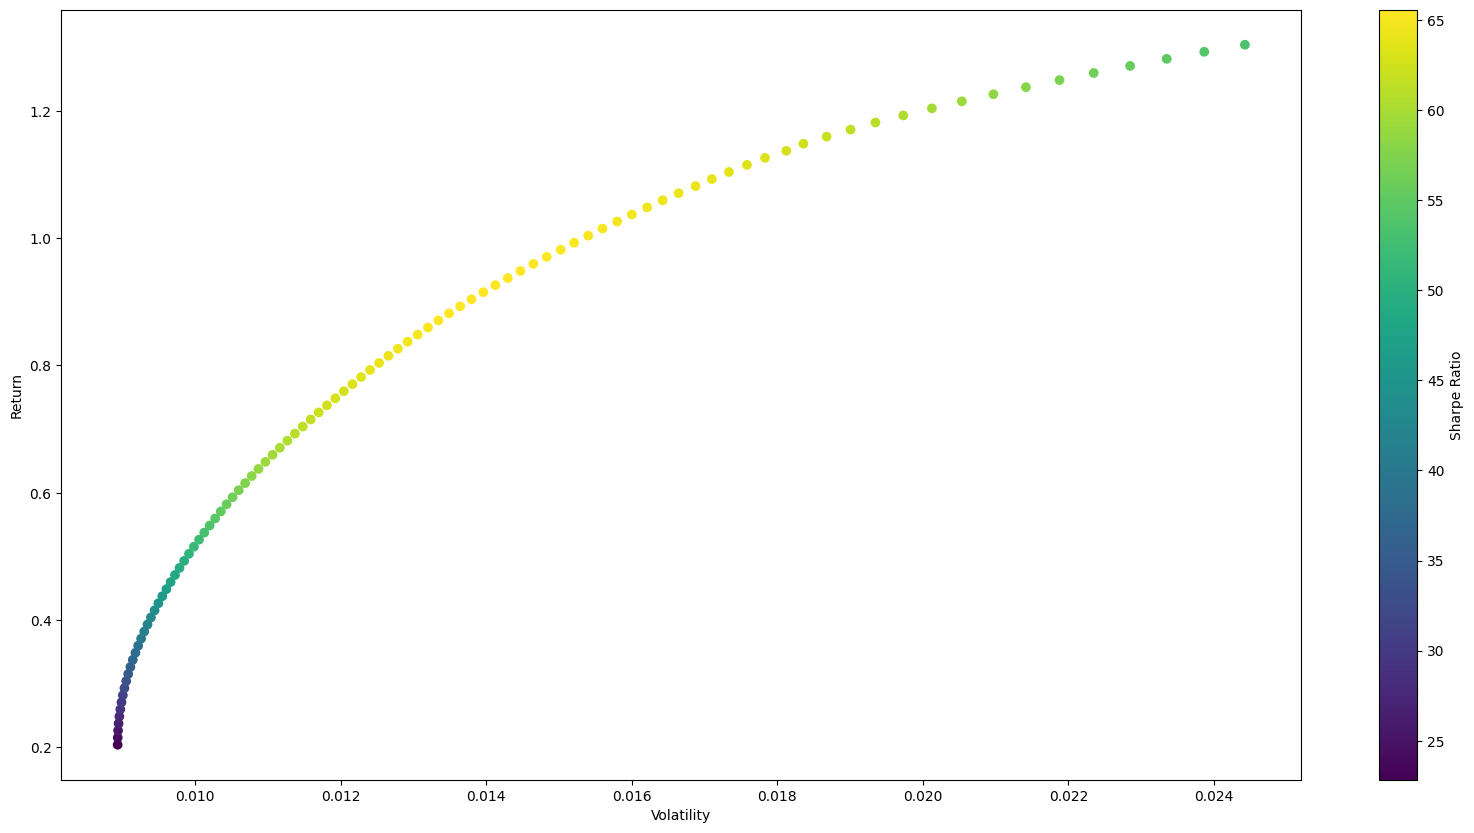

In [14]:
w = w_min
num_ports = 100
gap = (np.amax(r) - ret(r,w_min))/num_ports


all_weights = np.zeros((num_ports, len(df.columns)))
all_weights[0],all_weights[1]=w_min,w_sharpe
ret_arr = np.zeros(num_ports)
ret_arr[0],ret_arr[1]=ret(r,w_min),ret(r,w_sharpe)
vol_arr = np.zeros(num_ports)
vol_arr[0],vol_arr[1]=vol(w_min,covar),vol(w_sharpe,covar)

for i in range(num_ports):
    port_ret = ret(r,w) + i*gap
    double_constraint = LinearConstraint([np.ones(df2.shape[1]),r],[1,port_ret],[1,port_ret])

    #Create x0: initial guesses for weights.
    x0 = w_min
    #Define a function for portfolio volatility.
    fun = lambda w: np.sqrt(np.dot(w,np.dot(w,covar)))
    a = minimize(fun,x0,method='trust-constr',constraints = double_constraint,bounds = bounds)

    all_weights[i,:]=a.x
    ret_arr[i]=port_ret
    vol_arr[i]=vol(a.x,covar)

sharpe_arr = ret_arr/vol_arr

plt.figure(figsize=(20,10))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.show()

In [16]:
px.scatter(x=vol_arr, y=ret_arr)